In [64]:
import numpy as np 
import re # for regular expressions
import pandas as pd # handling databases, csv files, etc.
import sqlite3 as sql # for database management
import networkx as nx # for network analysis and graph visualization
import matplotlib.pyplot as plt # for plotting
import seaborn as sns # for plotting

### Download a GTFS status of the BKK from <https://bkk.hu/apps/gtfs/> this database changes almost on a daily basis, so include in your report the time you obtained it. (You don't have to keep it up to date.)

Loading the GTFS dataset (downloaded at 2022.10.31) into a Pandas DataFrames:

| Filename         | Defines                                                                                                   |
| ---------------  | --------------------------------------------------------------------------------------------------------- |
| agency.txt       | Transit agencies with service represented in this dataset.                                                |
| <b><span style="color:red">stops.txt</span></b>        | Stops where vehicles pick up or drop off riders. Also defines stations and station entrances.             |
| <b><span style="color:red">routes.txt</span></b>       | Transit routes. A route is a group of trips that are displayed to riders as a single service.             |
| <b><span style="color:red">trips.txt</span></b>        | Trips for each route. A trip is a sequence of two or more stops that occur during a specific time period. |
| <b><span style="color:red">stop\_times.txt</span></b>  | Times that a vehicle arrives at and departs from stops for each trip.                                     |
| shapes.txt       | Rules for mapping vehicle travel paths, sometimes referred to as route alignments.                        |
| pathways.txt     | Pathways linking together locations within stations.                                                      |

References:

  * [GTFS reference](developers.google.com/transit/gtfs/reference)

In [ ]:
agency = pd.read_csv('./gtfs/agency.txt')
calendar_dates = pd.read_csv('./gtfs/calendar_dates.txt')
feed_info = pd.read_csv('./gtfs/feed_info.txt')
pathways = pd.read_csv('./gtfs/pathways.txt')
routes = pd.read_csv('./gtfs/routes.txt')
shapes = pd.read_csv('./gtfs/shapes.txt')
stop_times = pd.read_csv('./gtfs/stop_times.txt')
stops = pd.read_csv('./gtfs/stops.txt')
trips = pd.read_csv('./gtfs/trips.txt')

# Data preprocessing

Some regex in the stops table for the stop names:
    
 * ` [\(\[].*?[\)\]]`: removing parentheses, brackets and everything between them
 * `i.rstrip(' ')`: removing trailing spaces
 * `i.rstrip('M')`: removing trailing M for metros
 * `i.rstrip('H')`: removing trailing H for HÉV
 * `i.rstrip('M+H')`: removing trailing M+H for metros and HÉV
 * `i.rstrip(' ')`: removing trailing spaces again, in case there was a space before the M or H

In [ ]:
stops['stop_name'] = [re.sub(" [\(\[].*?[\)\]]", "", str(i)) for i in stops.stop_name]
stops['stop_name'] = [i.rstrip(' ') for i in stops.stop_name]
stops['stop_name'] = [i.rstrip('M') for i in stops.stop_name]
stops['stop_name'] = [i.rstrip('H') for i in stops.stop_name]
stops['stop_name'] = [i.rstrip('M+H') for i in stops.stop_name]
stops['stop_name'] = [i.rstrip(' ') for i in stops.stop_name]

Zipping latitude and longitude into a single column in both shapes and stops tables for easier searching.
    
 * `zip(shapes.shape_pt_lat, shapes.shape_pt_lon)`
 * `zip(stops.stop_lat, stops.stop_lon)`

In [ ]:
shapes['location'] = np.array(zip(shapes.shape_pt_lat, shapes.shape_pt_lon))
stops['location'] = np.array(zip(stops.stop_lat, stops.stop_lon))

Saving them to csv, then loading the whole dataset into an sqlite database.

I did that manually in SQLite Studio, but it can be done with pandas as well:
 * `pd.read_csv('stops.txt').to_sql('stops', con=engine, if_exists='replace')`
 * `pd.read_csv('shapes.txt').to_sql('shapes', con=engine, if_exists='replace')`
 * etc...

In [ ]:
stops.to_csv('./gtfs/stops.csv', index=False)
shapes.to_csv('./gtfs/shapes.csv', index=False)

# Data analysis

### Create the link list of the transport routes! You can use the environment of your choice to calculate permutations if you don't want to do it in SQL.

Function for querying from the db and loading into a pandas dataframe.

In [2]:
def db_query(query):
    conn = sql.connect('gtfs/gtfs_new.db')
    df = pd.read_sql_query(query, conn)
    conn.close()
    return df

Query for stop names, locations and route names (query time is around 8.1 seconds):

``` sql
SELECT stop_name, location, stop_id, route_short_name
FROM
(SELECT route_stop.stop_id, stop_name, location, route_short_name
FROM
(SELECT distinct stop_id, route_short_name
FROM
(SELECT trips.route_id, trip_id, route_short_name FROM trips
INNER JOIN routes ON trips.route_id = routes.route_id) as trip_route
INNER JOIN stop_times ON trip_route.trip_id = stop_times.trip_id) as route_stop
INNER JOIN stops ON route_stop.stop_id = stops.stop_id)
```

In [12]:
query = """
SELECT stop_name, location, stop_id, route_short_name
FROM
(SELECT route_stop.stop_id, stop_name, location, route_short_name
FROM
(SELECT distinct stop_id, route_short_name
FROM
(SELECT trips.route_id, trip_id, route_short_name FROM trips
INNER JOIN routes ON trips.route_id = routes.route_id) as trip_route
INNER JOIN stop_times ON trip_route.trip_id = stop_times.trip_id) as route_stop
INNER JOIN stops ON route_stop.stop_id = stops.stop_id)
"""

df = db_query(query)
df.head()

,stop_name,location,stop_id,route_short_name
0,Csepel-Királyerdő,"(47.397886, 19.106529)",F04181,D14
1,"Soroksár, Molnár-sziget","(47.398244, 19.108689)",F04526,D14
2,Deák Ferenc tér,"(47.497413, 19.055158)",007884,47
3,Szent Gellért tér - Műegyetem,"(47.483616, 19.053537)",008591,47
4,Fővám tér,"(47.487186, 19.05781)",F00922,47


We need to self-join this table to get the network of routes (query time is around 95.8 seconds):

``` sql
SELECT a.stop_name as StopName_A,
b.stop_name as StopName_B,
a.location as Location_A,
b.location as Location_B,
a.stop_id as StopID_A,
b.stop_id as StopID_B,
a.route_short_name as Route_A,
b.route_short_name as Route_B,
a.route_color as RouteColor_A,
b.route_color as RouteColor_B
FROM
(SELECT route_stop.stop_id, stop_name, location, route_short_name, route_color
FROM
(SELECT distinct stop_id, route_short_name, route_color
FROM
(SELECT trips.route_id, trip_id, route_short_name, route_color FROM trips
INNER JOIN routes ON trips.route_id = routes.route_id) as trip_route
INNER JOIN stop_times ON trip_route.trip_id = stop_times.trip_id) as route_stop
INNER JOIN stops ON route_stop.stop_id = stops.stop_id) as a
INNER JOIN
(SELECT route_stop.stop_id, stop_name, location, route_short_name, route_color
FROM
(SELECT distinct stop_id, route_short_name, route_color
FROM
(SELECT trips.route_id, trip_id, route_short_name, route_color FROM trips
INNER JOIN routes ON trips.route_id = routes.route_id) as trip_route
INNER JOIN stop_times ON trip_route.trip_id = stop_times.trip_id) as route_stop
INNER JOIN stops ON route_stop.stop_id = stops.stop_id) as b
ON (a.stop_id < b.stop_id and a.stop_name = b.stop_name and a.location < b.location and a.route_short_name < b.route_short_name)
```

In [30]:
query = '''
SELECT a.stop_name as StopName_A,
b.stop_name as StopName_B,
a.location as Location_A,
b.location as Location_B,
a.stop_id as StopID_A,
b.stop_id as StopID_B,
a.route_short_name as Route_A,
b.route_short_name as Route_B,
a.route_color as RouteColor_A,
b.route_color as RouteColor_B
FROM
(SELECT route_stop.stop_id, stop_name, location, route_short_name, route_color
FROM
(SELECT distinct stop_id, route_short_name, route_color
FROM
(SELECT trips.route_id, trip_id, route_short_name, route_color FROM trips
INNER JOIN routes ON trips.route_id = routes.route_id) as trip_route
INNER JOIN stop_times ON trip_route.trip_id = stop_times.trip_id) as route_stop
INNER JOIN stops ON route_stop.stop_id = stops.stop_id) as a
INNER JOIN
(SELECT route_stop.stop_id, stop_name, location, route_short_name, route_color
FROM
(SELECT distinct stop_id, route_short_name, route_color
FROM
(SELECT trips.route_id, trip_id, route_short_name, route_color FROM trips
INNER JOIN routes ON trips.route_id = routes.route_id) as trip_route
INNER JOIN stop_times ON trip_route.trip_id = stop_times.trip_id) as route_stop
INNER JOIN stops ON route_stop.stop_id = stops.stop_id) as b
ON (a.stop_id < b.stop_id and a.stop_name = b.stop_name and a.location < b.location and a.route_short_name < b.route_short_name)
'''

df = db_query(query)
df.head()

,StopName_A,StopName_B,Location_A,Location_B,StopID_A,StopID_B,Route_A,Route_B,RouteColor_A,RouteColor_B
0,Deák Ferenc tér,Deák Ferenc tér,"(47.497413, 19.055158)","(47.497593, 19.053857)",007884,F00961,47,M2,FFD800,E41F18
1,Deák Ferenc tér,Deák Ferenc tér,"(47.497413, 19.055158)","(47.498843, 19.053605)",007884,F00960,47,M2,FFD800,E41F18
2,Deák Ferenc tér,Deák Ferenc tér,"(47.497413, 19.055158)","(47.49772, 19.05367)",007884,F00962,47,M1,FFD800,FFD800
3,Deák Ferenc tér,Deák Ferenc tér,"(47.497413, 19.055158)","(47.497728, 19.054142)",007884,F00963,47,M1,FFD800,FFD800
4,Deák Ferenc tér,Deák Ferenc tér,"(47.497413, 19.055158)","(47.49744, 19.055729)",007884,009309,47,934,FFD800,000000


### Extra idea: Calculating distances between stops

In [76]:
from geopy.distance import geodesic as GD

df_new = df.copy()
df_new['Location_A'] = df_new['Location_A'].apply(lambda x: eval(x))
df_new['Location_B'] = df_new['Location_B'].apply(lambda x: eval(x))
df_new['Distance_AB'] = df_new.apply(lambda x: np.round(GD(x['Location_A'], x['Location_B']).meters, 2), axis=1)
df_new.head()

,StopName_A,StopName_B,Location_A,Location_B,StopID_A,StopID_B,Route_A,Route_B,RouteColor_A,RouteColor_B,Distance_AB
0,Deák Ferenc tér,Deák Ferenc tér,"(47.497413, 19.055158)","(47.497593, 19.053857)",007884,F00961,47,M2,FFD800,E41F18,100.05
1,Deák Ferenc tér,Deák Ferenc tér,"(47.497413, 19.055158)","(47.498843, 19.053605)",007884,F00960,47,M2,FFD800,E41F18,197.41
2,Deák Ferenc tér,Deák Ferenc tér,"(47.497413, 19.055158)","(47.49772, 19.05367)",007884,F00962,47,M1,FFD800,FFD800,117.20
3,Deák Ferenc tér,Deák Ferenc tér,"(47.497413, 19.055158)","(47.497728, 19.054142)",007884,F00963,47,M1,FFD800,FFD800,84.18
4,Deák Ferenc tér,Deák Ferenc tér,"(47.497413, 19.055158)","(47.49744, 19.055729)",007884,009309,47,934,FFD800,000000,43.13


In [52]:
df_new.describe()

,Distance_AB
count,25441.000000
mean,1413.999490
std,4329.141104
min,2.910000
25%,57.330000
50%,106.890000
75%,188.480000
max,32759.280000


In [77]:
df_filtered = df_new[df_new['Distance_AB'] < 1000]
df_filtered.describe()

,Distance_AB
count,22629.000000
mean,123.300324
std,116.917710
min,2.910000
25%,52.870000
50%,95.510000
75%,152.580000
max,948.930000


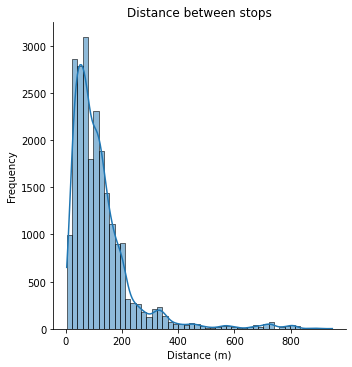

In [78]:
sns.displot(df_filtered['Distance_AB'], bins=50, kde=True)
plt.title('Distance between stops')
plt.xlabel('Distance (m)')
plt.ylabel('Frequency')
plt.show()

In [79]:
df_filtered['RouteColor_A'] = '#' + df_filtered['RouteColor_A']
df_filtered['RouteColor_B'] = '#' + df_filtered['RouteColor_B']
df_filtered.head()

C:\Users\gebha\AppData\Local\Temp\ipykernel_22264\262796733.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['RouteColor_A'] = '#'+ df_filtered['RouteColor_A']
C:\Users\gebha\AppData\Local\Temp\ipykernel_22264\262796733.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['RouteColor_B'] = '#' + df_filtered['RouteColor_B']


,StopName_A,StopName_B,Location_A,Location_B,StopID_A,StopID_B,Route_A,Route_B,RouteColor_A,RouteColor_B,Distance_AB
0,Deák Ferenc tér,Deák Ferenc tér,"(47.497413, 19.055158)","(47.497593, 19.053857)",007884,F00961,47,M2,#FFD800,#E41F18,100.05
1,Deák Ferenc tér,Deák Ferenc tér,"(47.497413, 19.055158)","(47.498843, 19.053605)",007884,F00960,47,M2,#FFD800,#E41F18,197.41
2,Deák Ferenc tér,Deák Ferenc tér,"(47.497413, 19.055158)","(47.49772, 19.05367)",007884,F00962,47,M1,#FFD800,#FFD800,117.20
3,Deák Ferenc tér,Deák Ferenc tér,"(47.497413, 19.055158)","(47.497728, 19.054142)",007884,F00963,47,M1,#FFD800,#FFD800,84.18
4,Deák Ferenc tér,Deák Ferenc tér,"(47.497413, 19.055158)","(47.49744, 19.055729)",007884,009309,47,934,#FFD800,#000000,43.13


### Visualize the network you've obtained! Nodes with more links should be bigger, color the nodes according to what kind of transport they're: black for nighttime, yellow for trams, blue for busses etc. and label them what route they're. What seem to be the most well connected nodes in this network? How can you fix this?          (<https://networkx.org/)>

In [80]:
G = nx.from_pandas_edgelist(df_filtered, 'Route_A', 'Route_B')

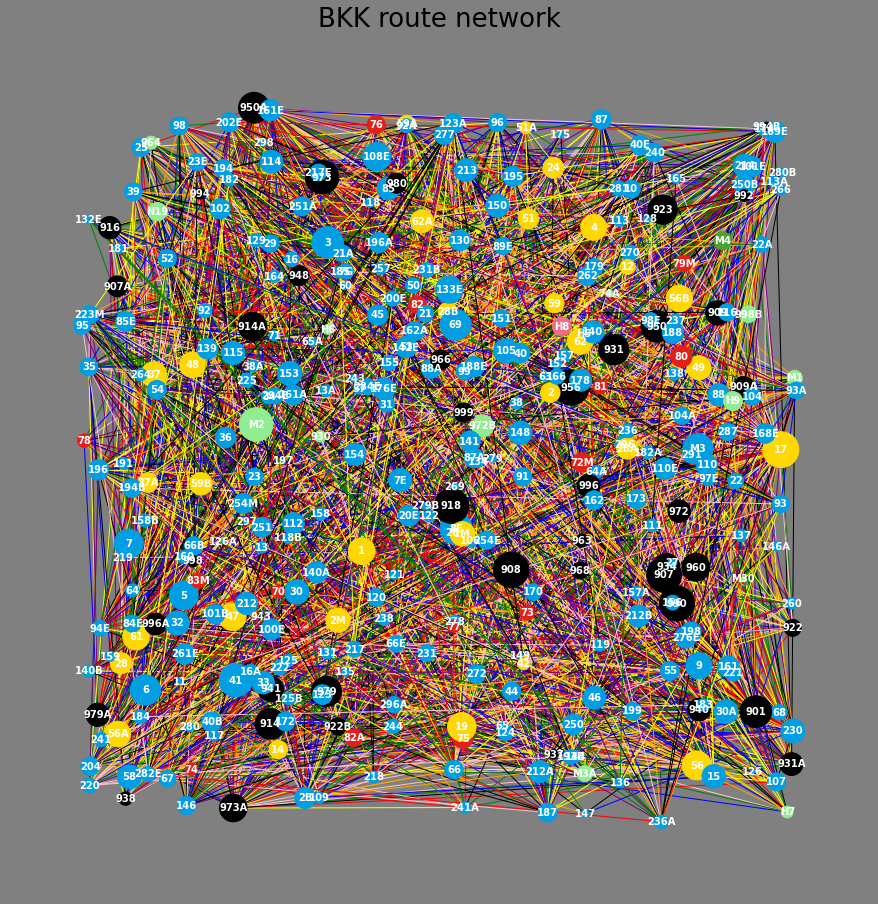

In [85]:
fig = plt.figure(figsize=(12,12))

d = dict(df_filtered.drop_duplicates(subset=['Route_A','RouteColor_A'])[['Route_A','RouteColor_A']].to_numpy().tolist())
nodes = G.nodes()
pos = nx.draw_random(G, with_labels=True, 
              nodelist=nodes,
              node_color=[d.get(i,'lightgreen') for i in nodes], 
              node_size=[v*10 for v in dict(G.degree()).values()],
              font_size=10,
              font_color='white',
              font_weight='bold',
              edge_color=np.random.choice(['red','blue','green','yellow','orange','purple','pink','black'], size=len(G.edges())))
fig.set_facecolor('gray')
plt.title('BKK route network', fontsize=26)
plt.show()

### Calculate the degree distribution and the average degree  of the >fixed< network. Visualize the results! What does the shape of the distribution tell you about this particular network?

The most connected routes are the nighttime routes and Tram 17, which is part of the 'Budai fonódó villamoshálózat'. Obviously the metros and longer bus routes are pretty well connected too.

In [86]:
most_degree = {n:d for n, d in G.degree()}
most_degree = sorted(most_degree.items(), key=lambda x: x[1], reverse=True)
most_degree[:20]

[('17', 129),
 ('908', 126),
 ('956', 125),
 ('990', 122),
 ('907', 121),
 ('918', 120),
 ('M2', 113),
 ('973', 113),
 ('41', 110),
 ('8E', 102),
 ('3', 100),
 ('901', 100),
 ('950', 98),
 ('950A', 95),
 ('69', 95),
 ('914', 94),
 ('931', 92),
 ('6', 92),
 ('M3', 91),
 ('979', 91)]

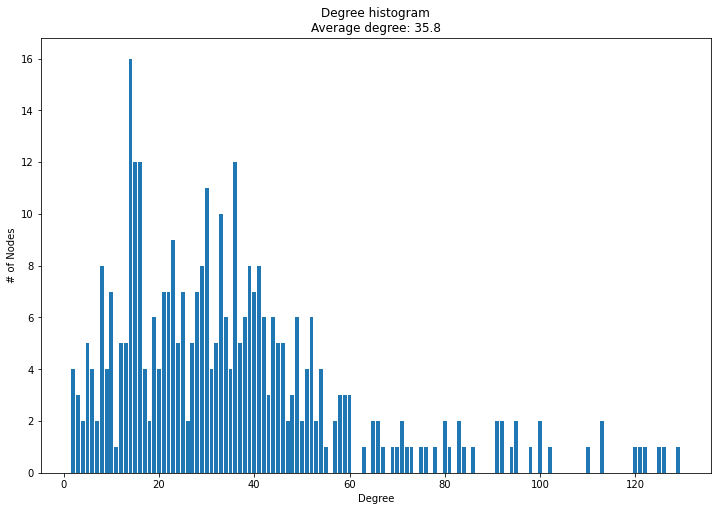

In [96]:
degree_sequence = sorted((d for n, d in G.degree()), reverse=True)
plt.figure(figsize=(12,8))
plt.bar(*np.unique(degree_sequence, return_counts=True))
plt.title(f"Degree histogram\nAverage degree: {np.round(np.mean(degree_sequence),2)}")
plt.xlabel("Degree")
plt.ylabel("# of Nodes")
plt.show()

### Calculate the clustering coefficient for each node, from that obtain the average clustering, and also calculate the global clustering coefficient!

### Visualize the results! How does the distribution look like? How does the average clustering compare to the global clustering?

In [102]:
clust = nx.clustering(G)
print(f'Global clustering coefficient: {nx.average_clustering(G)}\nMean of local clustering coefficients: {np.mean(list(clust.values()))}')

Global clustering coefficient: 0.6216797504575396
Mean of local clustering coefficients: 0.6216797504575396


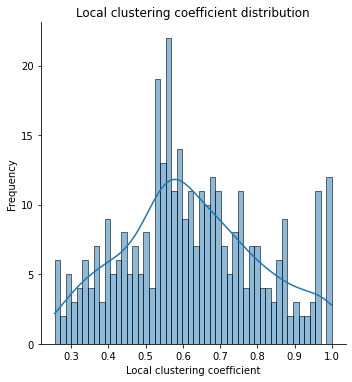

In [100]:
sns.displot(list(clust.values()), bins=50, kde=True)
plt.title('Local clustering coefficient distribution')
plt.xlabel('Local clustering coefficient')
plt.ylabel('Frequency')
plt.show()